In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import PIL
import io
import pyarrow

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns


import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
from pyspark import SparkContext, SparkConf
from pyspark.rdd import RDD

from pyspark.sql import SparkSession
#from pyspark.sql.types import *

from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#!pip install findspark
import findspark

import pyspark
pyspark.__version__

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from keras.layers import Dense, GlobalMaxPooling2D, Flatten

import sklearn.decomposition
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

import joblib
from joblib import dump

C:\Users\Alexis\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%matplotlib inline

In [3]:
pyspark.__version__

'3.1.2'

In [4]:
findspark.init()

In [5]:
#spark = SparkSession.builder.master("local")

In [6]:
#spark

Nous allons nous connecter a Spark en local dans un premier temps, afin de tester notre script.

Ma machine a 4 coeurs, nous allons donc initialiser notre session avec ce nombre de coeurs.

In [7]:
#conf = SparkConf().setAppName("Projet8")
#sc = SparkContext('local[4]', conf=conf)   
spark = SparkSession.builder.master("local[4]").appName('Projet8').getOrCreate()

In [8]:
#sc

In [9]:
spark

Nous pouvons passer à la classification des images, nous utiliserons SparkML pour cela, mais avant ça afin de récupérer les 'features' des images nous utiliserons un CNN, nous regarderons ce que nous aurons à notre disposition et lequel et le plus susceptible de convenir.

Dans un premier temps nous allons récupérer le chemin du dossier des images d'entraînement (les images étant déjà divisé en dossier d'entraînement et de test). Nous avons également 2 dossiers à notre disposition, un dossier contenant des images de taille quelconque (par exemple 479x420) et un dossier contenant des images à la taille 100x100, nous nous servirons de ces images, mais nous devrons les redimmensionner pour les utiliser avec le CNN choisit.

Les images à notre disposition sont des images de fruit, dans les dossiers Training et Test du dossier Fruit-360, nous aurons 131 classes de fruits différents à notre disposition, contenant chacun environ 500 images pour les dossiers Training et environ 150 images pour les dossiers Test.

Dans le dossier Fruit-360-original-size, nous aurons moins de choix à notre disposition puisqu'il n'y aura plus que 24 classes, avec environ 300 images pour les dossiers de Training et 150 images pour les dossiers Test.

Il y a également d'autre dossiers mais nous utiliserons partculièrement ceux cités plus haut. Nous aurons notamment un dossier test-multiple_fruits, qui contiendra des images avec plusieurs fruits comme on peu s'en douter.

De même pour la suite nous n'utiliserons pas tous les dossiers, nous n'en utiliserons que 6, dont 3 dossiers de pomme afin de voir les résultats de la classification et de ne pas perdre trop de temps en calcul.

In [10]:
img_dir = r"C:/Users/Alexis/image100/Training"

Regardons les classes a notre disposition:

In [11]:
nombreDeCategorie = os.listdir(img_dir)
print(nombreDeCategorie)

['Apple_Golden_2', 'Apple_Golden_3', 'Apple_Red_2', 'Kaki', 'Mangostan', 'Peach']


Comme mentionné plus haut nous confronterons le machine learning à des classes très similaires et des classes assez éloignées.

Plaçons nous dans un des dossiers:

In [12]:
img_dir_Peach = r"C:\Users\Alexis\image100\Training\Peach"

In [13]:
list = os.listdir(img_dir_Peach)
print(list)

['0_100.jpg', '100_100.jpg', '101_100.jpg', '102_100.jpg', '103_100.jpg', '104_100.jpg', '105_100.jpg', '106_100.jpg', '107_100.jpg', '108_100.jpg', '109_100.jpg', '10_100.jpg', '110_100.jpg', '111_100.jpg', '112_100.jpg', '113_100.jpg', '114_100.jpg', '115_100.jpg', '116_100.jpg', '117_100.jpg', '118_100.jpg', '119_100.jpg', '11_100.jpg', '120_100.jpg', '121_100.jpg', '122_100.jpg', '123_100.jpg', '124_100.jpg', '125_100.jpg', '126_100.jpg', '127_100.jpg', '128_100.jpg', '129_100.jpg', '12_100.jpg', '130_100.jpg', '131_100.jpg', '132_100.jpg', '133_100.jpg', '134_100.jpg', '135_100.jpg', '136_100.jpg', '137_100.jpg', '138_100.jpg', '139_100.jpg', '13_100.jpg', '140_100.jpg', '141_100.jpg', '142_100.jpg', '143_100.jpg', '144_100.jpg', '145_100.jpg', '146_100.jpg', '147_100.jpg', '148_100.jpg', '149_100.jpg', '14_100.jpg', '150_100.jpg', '151_100.jpg', '152_100.jpg', '153_100.jpg', '154_100.jpg', '155_100.jpg', '156_100.jpg', '157_100.jpg', '158_100.jpg', '159_100.jpg', '15_100.jpg', '1

Essayons de voir à quoi ressemble les images:

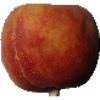

In [14]:
img_dir_Peach0 = r"C:\Users\Alexis\image100\Training\Peach\0_100.jpg"
img_show = PIL.Image.open(img_dir_Peach0)
img_show

Renseignons nous sur ces images avec Spark:

In [15]:
peach_df = spark.read.format('image').load(img_dir_Peach) 

In [16]:
peach_df

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

Nous pouvons voir que chaque image va avoir  6 paramètres différents, regardons ça d'un peu plus près:

In [17]:
peach_df.select('image.origin', 'image.height', 'image.width', 'image.nChannels', 'image.mode', 'image.data').show(5)

+--------------------+------+-----+---------+----+--------------------+
|              origin|height|width|nChannels|mode|                data|
+--------------------+------+-----+---------+----+--------------------+
|file:///C:/Users/...|   100|  100|        3|  16|[F9 FF FA FA FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FA FF F5 FB FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[F8 FF F6 F9 FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FB FF FF FB FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[F8 FF F4 F9 FF F...|
+--------------------+------+-----+---------+----+--------------------+
only showing top 5 rows



Nous allons ajouter le label des images a notre dataframe, regardons plus en détail la forme de image.origin:

In [18]:
peach_df.select('image.origin').show(5, False)

+-------------------------------------------------------------+
|origin                                                       |
+-------------------------------------------------------------+
|file:///C:/Users/Alexis/image100/Training/Peach/r_10_100.jpg |
|file:///C:/Users/Alexis/image100/Training/Peach/r_11_100.jpg |
|file:///C:/Users/Alexis/image100/Training/Peach/r_311_100.jpg|
|file:///C:/Users/Alexis/image100/Training/Peach/r_320_100.jpg|
|file:///C:/Users/Alexis/image100/Training/Peach/r_2_100.jpg  |
+-------------------------------------------------------------+
only showing top 5 rows



Pour récupérer le label, nous pouvons utiliser split, c'est ce que nous allons essayer:

In [19]:
from pyspark.sql.functions import split

In [20]:
label0 = peach_df.withColumn("Label0", split(peach_df['image.origin'], "///").getItem(1))

In [21]:
label0.select('Label0').show(5, False)

+-----------------------------------------------------+
|Label0                                               |
+-----------------------------------------------------+
|C:/Users/Alexis/image100/Training/Peach/r_10_100.jpg |
|C:/Users/Alexis/image100/Training/Peach/r_11_100.jpg |
|C:/Users/Alexis/image100/Training/Peach/r_311_100.jpg|
|C:/Users/Alexis/image100/Training/Peach/r_320_100.jpg|
|C:/Users/Alexis/image100/Training/Peach/r_2_100.jpg  |
+-----------------------------------------------------+
only showing top 5 rows



In [22]:
peach_dfLabel = label0.withColumn("Label", split(label0['Label0'], "/").getItem(5))

In [23]:
peach_dfLabel.select('image.origin', 'Label').show(1, False)

+------------------------------------------------------------+-----+
|origin                                                      |Label|
+------------------------------------------------------------+-----+
|file:///C:/Users/Alexis/image100/Training/Peach/r_10_100.jpg|Peach|
+------------------------------------------------------------+-----+
only showing top 1 row



Faisons de même pour les images de nos autres dataframes:

In [24]:
img_dirAll = r"C:/Users/Alexis/image100/Training/*"

In [25]:
allImage_df = spark.read.format('image').load(img_dirAll, inferschema = True) 

In [26]:
allImage_df

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [27]:
allImage_df.select('image.origin', 'image.height', 'image.width', 'image.nChannels', 'image.mode', 'image.data').show(5)

+--------------------+------+-----+---------+----+--------------------+
|              origin|height|width|nChannels|mode|                data|
+--------------------+------+-----+---------+----+--------------------+
|file:///C:/Users/...|   100|  100|        3|  16|[FF FF FF FF FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FF FF FF FF FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FF FF FF FF FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FF FF FF FF FF F...|
|file:///C:/Users/...|   100|  100|        3|  16|[FF FF FF FF FF F...|
+--------------------+------+-----+---------+----+--------------------+
only showing top 5 rows



In [28]:
labelAll0 = allImage_df.withColumn("Label0", split(allImage_df['image.origin'], "///").getItem(1))

In [29]:
allImage_dfLabel = labelAll0.withColumn("Label", split(labelAll0['Label0'], "/").getItem(5))

In [30]:
#allImage_dfLabel.select('image.origin', 'Label').show(2000, False)

In [31]:
allImage_dfLabel.select('image.origin', 'Label').show(1, False)

+----------------------------------------------------------------+---------+
|origin                                                          |Label    |
+----------------------------------------------------------------+---------+
|file:///C:/Users/Alexis/image100/Training/Mangostan/r_42_100.jpg|Mangostan|
+----------------------------------------------------------------+---------+
only showing top 1 row



Maintenant que nous avons récupérer les labels pour nos images, nous pouvons passer à la classification, mais au lieu d'utiliser toutes les données des images nous allons essayer de réduire les dimensions comme nous avions pu faire pour le projet6 avec une acp, mais ce coup ci au lieu d'utiliser SIFT ou ORB pour récupérer les bagofwords, nous allons utiliser un CNN, d'après la littérature Xception ou MobileNetV2 semblent convenir, car ils sont rapide et donnent de bons résultats.

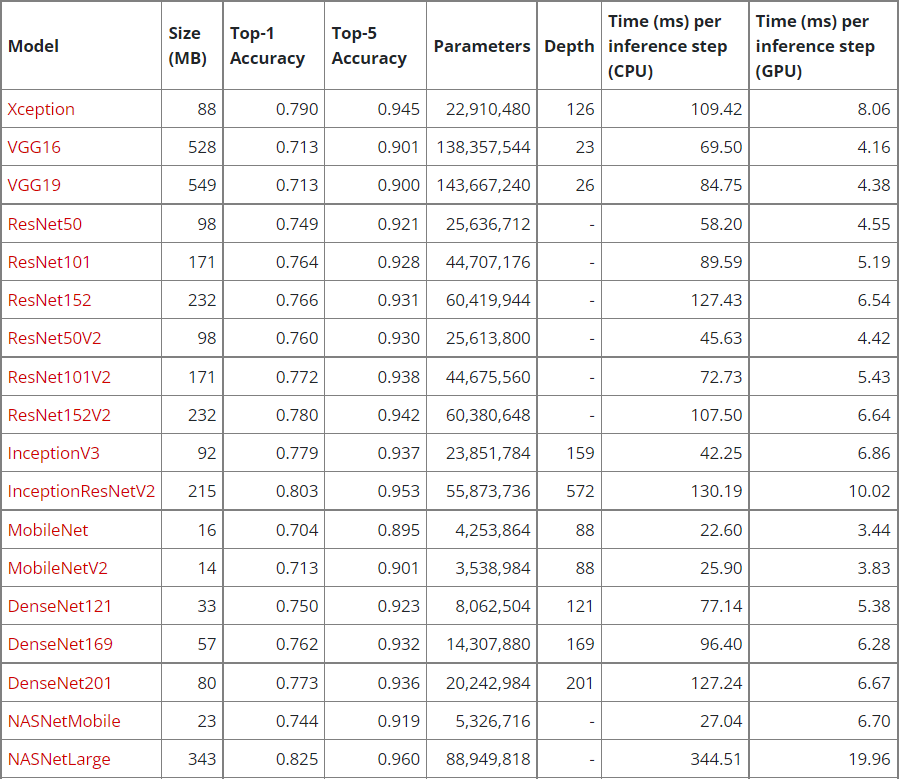

Comme nous pouvons le voir Xception fait parti des meilleurs CNN en terme de taux de bonne classification et n'est pas trop lourd, cependant il a des temps par étape assez élevés, contrairement à MobileNetV2 qui est plus rapide pour un taux de bonne classifiaction plus faible en contre parti, mais beaucoup plus léger et qui possède tout de même un bon taux de bonne classification.

Nous allons donc nous attarder sur MobileNetV2 pour la suite.

In [32]:
model = MobileNetV2(include_top = False, input_shape=(224, 224, 3), weights = "imagenet", pooling = 'max')

Regardons à quoi ressemble notre CNN:

In [33]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Comme nous pouvons le voir les images en entrée sont de la forme 224x224, nous allons devoir transformer nos images dans un premier temps.

De même pour le redimmensionnement nous utiliserons les raw data des images, pour cette raison nous chargerons nos image au format binaryFile.

Nous pourrion également utiliser sc.binaryfiles qui nous donne les mêmes résultats (sans les colonnes modificationTime et length) mais cette dernière est plus longue, de même nous n'avons pas le même type de données, alors que ce dernier va nous donner un type RDD,spark.read.format("binaryFile") va nous donner un dataframe, ce qui est "mieux" pour un data scientist.

In [34]:
imagesALL_df = spark.read.format("binaryFile").load(img_dirAll, inferschema = True)

In [35]:
imagesALL_dfLabel = imagesALL_df.withColumn("Label", split(imagesALL_df['path'], "/").getItem(6))

Comme nous l'avons vu plus haut nous avons plusieurs classes à notre disposition qui sont 'Apple_Golden_2', 'Apple_Golden_3', 'Apple_Red_2', 'Kaki', 'Mangostan' et 'Peach', nous pourrions ajouter le numéro de la classe avec lit, mais nous devrions nous y reprendre à chaque fois que nous ajouterons un classe, nous allons donc utiliser la fonction StringIndexer comme on a pu apprendre dans le cours:

In [36]:
label_indexer = StringIndexer(inputCol="Label", outputCol="Label_index")
label_indexer_transformer = label_indexer.fit(imagesALL_dfLabel)
imagesALL_dfLabel = label_indexer_transformer.transform(imagesALL_dfLabel)

In [37]:
imagesALL_dfLabel.show(1)

+--------------------+--------------------+------+--------------------+---------+-----------+
|                path|    modificationTime|length|             content|    Label|Label_index|
+--------------------+--------------------+------+--------------------+---------+-----------+
|file:/C:/Users/Al...|2022-01-05 15:34:...|  6113|[FF D8 FF E0 00 1...|Mangostan|        5.0|
+--------------------+--------------------+------+--------------------+---------+-----------+
only showing top 1 row



In [38]:
imagesALL_dfLabel.select('path', 'Label').show(imagesALL_dfLabel.count(), False)

+--------------------------------------------------------------------+--------------+
|path                                                                |Label         |
+--------------------------------------------------------------------+--------------+
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_42_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_43_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_41_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_44_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_40_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_39_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_47_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_46_100.jpg      |Mangostan     |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_4

Nous avons bien récupérer le label de nos images, passons à la suite.

Commencons par prétraiter nos images, en les redimmensionnant. Ce redimmensionnement se fera à l'appel de l'image, nous aurions pu transformer nos images directement et les enregistrer dans un nouveau dossier, mais cela prendrait trop de temps et surtout si la base de données change il faudra retransformer ces images "à la main".

In [39]:
def preprocess(content):
    image = PIL.Image.open(io.BytesIO(content))
    imageResize = image.resize([224, 224])
    imageArray = img_to_array(imageResize)
    preprocessingImage = preprocess_input(imageArray)
    return preprocessingImage

Nous utiliserons les poids de ImageNet, le modèle a déjà était entraîné sur des images de fruits, donc il n'y aurait pas d'intérêt à refaire un entraînement depuis le début.

In [40]:
def model_MobileNetV2():
    model = MobileNetV2(include_top = False, input_shape=(224, 224, 3), weights = "imagenet", pooling = 'max')
    return model

Nous allons maintenant récupérer les features de chaques images:

In [41]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [42]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    model = model_MobileNetV2()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\Spark\spark-3.1.2-bin-hadoop3.2\python\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [43]:
features_df = imagesALL_dfLabel.select("path", 'Label', 'Label_index', featurize_udf("content"))

Afin d'optimiser notre code nous allons enregistrer features_df en mémoire, ça nous permettra d'éviter de réaliser des actions deux fois (ici l'appel à featurize_udf):

In [44]:
features_df.persist()

DataFrame[path: string, Label: string, Label_index: double, featurize_udf(content): array<float>]

In [45]:
features_df.show(1)

+--------------------+---------+-----------+----------------------+
|                path|    Label|Label_index|featurize_udf(content)|
+--------------------+---------+-----------+----------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|  [1.7851162, 0.0, ...|
+--------------------+---------+-----------+----------------------+
only showing top 1 row



In [46]:
features_df.count()

2747

In [47]:
features_df = features_df.withColumnRenamed("featurize_udf(content)", "Features")

In [48]:
features_df.show(1)

+--------------------+---------+-----------+--------------------+
|                path|    Label|Label_index|            Features|
+--------------------+---------+-----------+--------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|[1.7851162, 0.0, ...|
+--------------------+---------+-----------+--------------------+
only showing top 1 row



Regardons le forme de nos données Features:

In [49]:
featurefd = features_df.select('Features')

In [50]:
featurefd_Panda = featurefd.toPandas()

In [51]:
len(featurefd_Panda['Features'][0])

1280

Nous devons convertir nos features au format 'org.apache.spark.ml.linalg.VectorUDT' dans un premier temps, pour pouvoir utiliser l'ACP de Pyspark:

In [52]:
from pyspark.ml.feature import PCA, StandardScaler

In [53]:
conversionVectorUDT = udf(lambda feature: Vectors.dense(feature), VectorUDT())

In [54]:
features_df = features_df.withColumn("VectorUdt", conversionVectorUDT('Features'))

In [55]:
features_df.show(1)

+--------------------+---------+-----------+--------------------+--------------------+
|                path|    Label|Label_index|            Features|           VectorUdt|
+--------------------+---------+-----------+--------------------+--------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|[1.7851162, 0.0, ...|[1.78511619567871...|
+--------------------+---------+-----------+--------------------+--------------------+
only showing top 1 row



Avant de faire notre ACP nous allons séparer nos données en jeu d'entraînement et jeu de test:

In [56]:
acp_train, acp_test = features_df.randomSplit([0.7, 0.3], seed = 7)

Pour la suite nous allons réduire la dimension de nos données, nous avons tracer la courbe d'inertie, nous avons dans un premier temps pris un nombre élevé pour k, nous avons pris k = 75, puis nous avons tracer la courbe, le code sera donné en commentaire mais ne sera pas utiliser ici, nous afficherons la courbe:

In [57]:
#pca = PCA(k = 75, inputCol = 'VectorUdt', outputCol = 'X_acp')
#model = pca.fit(acp_train)
#acp_df = model.transform(acp_train)

#nombreK = 0
#somme = 0
#listeI = []
#listeSomme = []
#for i in range(len(model.explainedVariance)):
#    if somme < 0.75:
#        somme = somme + model.explainedVariance[i]
#        listeI.append(i)
#        listeSomme.append(somme)
#        nombreK += 1
#
#print(somme)
#print(nombreK)
#
#import matplotlib.pyplot as plt
#plt.plot(listeI, listeSomme)
#plt.show()

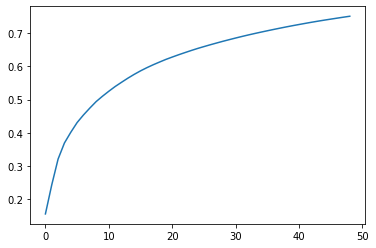

Pour la suite, à la vue de ce graphe nous prendrons donc k = 5, d'après la méthode du coude.

In [58]:
pca = PCA(k = 5, inputCol = 'VectorUdt', outputCol = 'X_acp')
model = pca.fit(acp_train)
acp_df = model.transform(acp_train)

In [59]:
acp_df.show(1)

+--------------------+---------+-----------+--------------------+--------------------+--------------------+
|                path|    Label|Label_index|            Features|           VectorUdt|               X_acp|
+--------------------+---------+-----------+--------------------+--------------------+--------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|[4.562498, 0.0, 0...|[4.56249809265136...|[-36.185872698178...|
+--------------------+---------+-----------+--------------------+--------------------+--------------------+
only showing top 1 row



Nous pouvons maintenant passer à la classification après un entraînement:

In [60]:
lr = LogisticRegression(maxIter = 20, regParam = 0.05, elasticNetParam = 0.3, labelCol = "Label_index", featuresCol = 'X_acp')
p_model = lr.fit(acp_df)

In [61]:
acp_Test = model.transform(acp_test)
predictions = p_model.transform(acp_Test)

In [62]:
predictions.select("path", "Label", "Label_index", "prediction").show(25, False)

+--------------------------------------------------------------+---------+-----------+----------+
|path                                                          |Label    |Label_index|prediction|
+--------------------------------------------------------------+---------+-----------+----------+
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_34_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_37_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_39_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_41_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_42_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_44_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_46_100.jpg|Mangostan|5.0        |5.0       |
|file:/C:/Users/Alex

Nous pouvons voir que des erreurs existe, ce qui n'est pas étonnant à la vue des classes que nous avons prises.

Pour évaluer notre classification multi-classes, nous utiliserons un modèle qui évaluera les prédictions. Nous utiliserons MulticlassClassificationEvaluator avec les métriques F1 et Accuracy.

F1 est une moyenne pondérée des scores de précision et de rappel qui sont:

    - Précision : Correspond au nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images       prédites comme appartenant à la classe i.
    
    - Rappel : Correspond au nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images           appartenant à la classe i.   
    
La mesure F1 est à préférer si nos données sont déséquilibrées, ici ce ne sera pas le cas car nos classes ont un nombre d'images assez proche, comme nous allons voir, mais nous ne savons pas ce qu'il en sera demain et c'est pour cette raison nous évaluerons la précision et F1.

In [63]:
predictions.groupBy("Label").count().show()

+--------------+-----+
|         Label|count|
+--------------+-----+
|         Peach|  142|
|Apple_Golden_3|  143|
|   Apple_Red_2|  138|
|          Kaki|  151|
|     Mangostan|   92|
|Apple_Golden_2|  156|
+--------------+-----+



Nous pouvons voir que la classe Mangoustan est assez déséquilibrée par rapport aux autres, la métrique F1 trouve son intérêt ici.

In [64]:
evaluatorF1 = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "f1")

In [65]:
print("F1 = ", evaluatorF1.evaluate(predictions))

F1 =  0.8758190830940009


In [66]:
evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "accuracy")

In [67]:
print("Accuracy = ", evaluatorAccuracy.evaluate(predictions))

Accuracy =  0.8771289537712895


Regardons également la matrice de confusion pour avoir plus d'informations:

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [69]:
y_true = predictions.select("Label_index")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(len(nombreDeCategorie)))

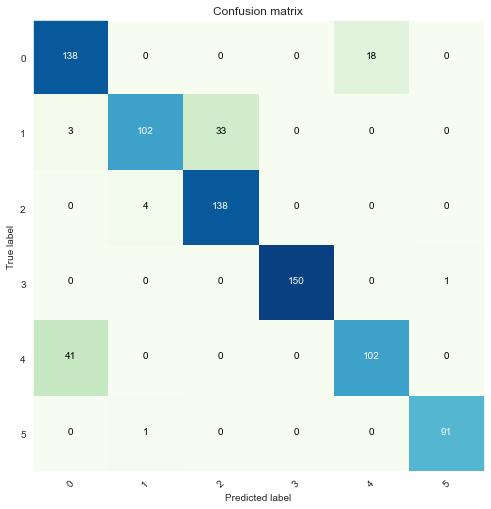

In [70]:
sns.set_style("darkgrid")
plt.figure(figsize = (7,7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes = range(len(nombreDeCategorie)))

Nous pouvons voir que nos résultats collent plutôt bien à ce qu'on trouve dans la littérature.

Mais nous pouvons sûrement améliorer ces résultats et pour ça nous pouvons utiliser les fonctions ParamGridBuilder et CrossValidator, qui vont correspondre aux classes GridSearchCV et CrossValidation de python (en faisant un rapide raccourci).

Nous nous focaliserions sur la métrique F1 pour les raisons évoquées plus haut.

In [71]:
paramGrid = (ParamGridBuilder()
  .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
  .addGrid(lr.maxIter, [10, 20, 50]) \
  .addGrid(lr.elasticNetParam, [0.0, 0.8]) \
  .build())

In [72]:
crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorF1,
                          numFolds = 3)

In [73]:
modelOpt = crossval.fit(acp_df)

In [74]:
predictionsOpt = modelOpt.transform(acp_Test)

In [75]:
print("F1 Opt = ", evaluatorF1.evaluate(predictionsOpt))

F1 Opt =  0.9241686825971183


Regardons rapidement la nouvelle matrice de confusion:

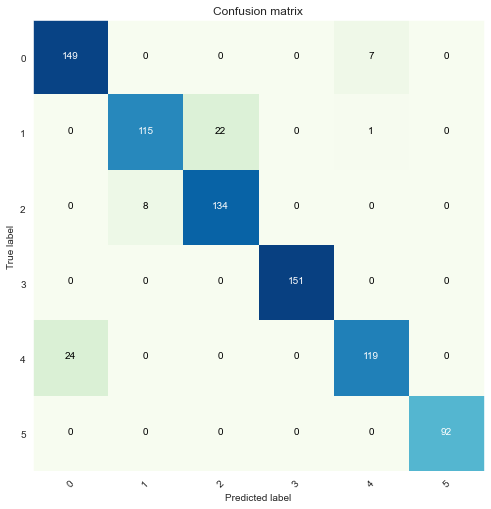

In [76]:
y_true = predictionsOpt.select("Label_index")
y_true = y_true.toPandas()
y_pred = predictionsOpt.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(len(nombreDeCategorie)))

sns.set_style("darkgrid")
plt.figure(figsize = (7,7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes = range(len(nombreDeCategorie)))

Les 2 fonctions opérent une amélioration, nous pourrions peut être l'améliorer encore un peu en choisissant plus de paramètre a tester. Si aucune amélioration n'est réalisé il faudrait réfléchir à utiliser un autre modèle, fournir plus d'image d'entraînement ou revoir votre méthode.

Enrigistrons maintenant nos résultats, nous les enregistrerons après une conversion avec toPandas(), afin de pouvoir utiliser ces derniers aussi bien avec pyspark qu'avec le python plus traditionnel:

In [77]:
resultattoPandas = predictionsOpt.toPandas()
resultattoPandas.head()

,path,Label,Label_index,Features,VectorUdt,X_acp,rawPrediction,probability,prediction
0,file:/C:/Users/Alexis/image100/Training/Mangos...,Mangostan,5.0,"[3.0491013526916504, 0.0, 0.0, 0.0, 0.07477903...","[3.0491013526916504, 0.0, 0.0, 0.0, 0.07477903...","[-37.963462733621085, 3.4001278901011798, 26.0...","[-3.8267767257430645, 0.34733235471557866, 0.2...","[0.0005824727958716171, 0.037850200740883605, ...",5.0
1,file:/C:/Users/Alexis/image100/Training/Mangos...,Mangostan,5.0,"[4.600798606872559, 0.0, 0.0, 0.0, 0.0, 0.0, 6...","[4.600798606872559, 0.0, 0.0, 0.0, 0.0, 0.0, 6...","[-38.38649165838938, 4.919488125177037, 28.747...","[-3.9080743452328797, 0.06770676815341659, 0.4...","[0.00048145081859821956, 0.02565734584578946, ...",5.0
2,file:/C:/Users/Alexis/image100/Training/Mangos...,Mangostan,5.0,"[4.255337715148926, 0.0, 0.0, 0.0, 0.475001811...","[4.255337715148926, 0.0, 0.0, 0.0, 0.475001811...","[-36.023718419944835, 3.5259307764327295, 24.1...","[-3.691485180693097, 0.42738847509065336, 0.56...","[0.0009985112816647407, 0.06139840319423162, 0...",5.0
3,file:/C:/Users/Alexis/image100/Training/Mangos...,Mangostan,5.0,"[3.5107421875, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 1...","[3.5107421875, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 1...","[-33.03151758570071, 2.999800887420161, 23.157...","[-3.4116963999847503, 0.44623941247359333, 0.6...","[0.001610215059603093, 0.07627182163545218, 0....",5.0
4,file:/C:/Users/Alexis/image100/Training/Mangos...,Mangostan,5.0,"[1.785116195678711, 0.0, 0.0, 0.0, 0.0, 0.0, 6...","[1.785116195678711, 0.0, 0.0, 0.0, 0.0, 0.0, 6...","[-32.70232472428304, 7.017785666635304, 24.570...","[-2.980174100750643, 0.14219945498124842, -0.0...","[0.0022244346085050428, 0.05049510144675194, 0...",5.0


In [78]:
joblib.dump(resultattoPandas, r'C:\Users\Alexis\resultattoPandas.joblib')

['C:\\Users\\Alexis\\resultattoPandas.joblib']

Nous pouvons regarder ce que nous aurons avec un autre CNN, nous allons essayer Xception qui compte parmi les plus performants:

In [79]:
def preprocessX(content):
    image = PIL.Image.open(io.BytesIO(content))
    imageResize = image.resize([299, 299])
    imageArray = img_to_array(imageResize)
    preprocessingImage = preprocess_input(imageArray)
    return preprocessingImage

In [80]:
def model_Xception():
    model = Xception(include_top=False, input_shape=(299, 299, 3), weights = "imagenet", pooling = 'max')
    return model

In [81]:
def featurize_seriesX(model, content_series):
    input = np.stack(content_series.map(preprocessX))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [82]:
 @pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
 def featurize_udfX(content_series_iter):
     model = model_Xception()
     for content_series in content_series_iter:
         yield featurize_seriesX(model, content_series)

C:\Spark\spark-3.1.2-bin-hadoop3.2\python\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [83]:
features_dfXception = imagesALL_dfLabel.select("path", 'Label', 'Label_index', featurize_udfX("content"))

In [84]:
features_dfXception.persist()

DataFrame[path: string, Label: string, Label_index: double, featurize_udfX(content): array<float>]

In [85]:
features_dfXception.show(1)

+--------------------+---------+-----------+-----------------------+
|                path|    Label|Label_index|featurize_udfX(content)|
+--------------------+---------+-----------+-----------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|   [2.1828885, 0.174...|
+--------------------+---------+-----------+-----------------------+
only showing top 1 row



In [86]:
features_dfXception = features_dfXception.withColumnRenamed("featurize_udfX(content)", "Features")

In [87]:
features_dfXception.show(1)

+--------------------+---------+-----------+--------------------+
|                path|    Label|Label_index|            Features|
+--------------------+---------+-----------+--------------------+
|file:/C:/Users/Al...|Mangostan|        5.0|[2.1828885, 0.174...|
+--------------------+---------+-----------+--------------------+
only showing top 1 row



In [88]:
features_dfXception = features_df.withColumn("VectorUdt", conversionVectorUDT('Features'))

In [89]:
###featurefdX = features_dfXception.select('Features')

In [90]:
###featurefd_PandaX = featurefdX.toPandas()

In [91]:
###len(featurefd_PandaX['Features'][0])

Nous avons plus de 'features' (2048) qu'avec le modèle MobileNetV2(1280), voyons voir ce que nous donne la suite, comme précèdemment nous allons effectuer une acp et chercher le meilleur k:

In [92]:
acp_trainX, acp_testX = features_dfXception.randomSplit([0.7, 0.3], seed = 7)

In [93]:
pcaX = PCA(k = 5, inputCol = 'VectorUdt', outputCol = 'X_acp')
modelX = pcaX.fit(acp_trainX)
acp_dfX = modelX.transform(acp_trainX)

In [94]:
lr = LogisticRegression(maxIter = 20, regParam = 0.05, elasticNetParam = 0.3, labelCol = "Label_index", featuresCol = 'X_acp')
p_modelX = lr.fit(acp_dfX)

In [95]:
acp_TestX = modelX.transform(acp_testX)
predictionsX = p_modelX.transform(acp_TestX)
predictionsX.select("path", "Label", "Label_index", "prediction").show(45, False)

+---------------------------------------------------------------+---------+-----------+----------+
|path                                                           |Label    |Label_index|prediction|
+---------------------------------------------------------------+---------+-----------+----------+
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_34_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_37_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_39_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_41_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_42_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_44_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/Users/Alexis/image100/Training/Mangostan/r_46_100.jpg |Mangostan|5.0        |5.0       |
|file:/C:/

In [96]:
evaluatorF1 = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "f1")

In [97]:
print("F1 = ", evaluatorF1.evaluate(predictionsX))

F1 =  0.8758190830940009


In [98]:
evaluatorAccuracy = MulticlassClassificationEvaluator(labelCol = "Label_index", predictionCol = "prediction", metricName = "accuracy")

In [99]:
print("Accuracy = ", evaluatorAccuracy.evaluate(predictionsX))

Accuracy =  0.8771289537712895


Nous obtenons les mêmes résultats qu'avec le modèle MobileNetV2, nous utiliserons donc ce dernier pour la suite car il est plus léger et plus rapide de manière générale.

## Validation

Nous allons nous attaquer à la partie test, nous avons entraîné nos modèles avec des images à notre disposition, mais nous devons maintenant gérer les nouvelles images qui arriveront, pour cela nous ferons appel à ce que nous avons déjà vu, comme le preprocessing de l'image (modifier la taille de l'image notamment), récupérer les features de l'image et enfin la classifier.

C'est cette partie que nous utiliserons si nous voulons classifier de nouvelles images par la suite.
Elle est mise en place ici mais ne sera pas utilisée.

Commencons par charger nos images de test:

In [100]:
img_dirTest = r"C:/Users/Alexis/image100/Test/*"

In [101]:
imageTest_df = spark.read.format("binaryFile").load(img_dirTest, inferschema = True)

In [102]:
imageTest_dfLabel = imageTest_df.withColumn("Label", split(imageTest_df['path'], "/").getItem(6))

label_indexer = StringIndexer(inputCol="Label", outputCol="Label_index")
label_indexer_transformer = label_indexer.fit(imageTest_dfLabel)
imageTest_dfLabel = label_indexer_transformer.transform(imageTest_dfLabel)

In [103]:
def preprocessTest(content):
    image = PIL.Image.open(io.BytesIO(content))
    imageResize = image.resize([224, 224])
    imageArray = img_to_array(imageResize)
    preprocessingImage = preprocess_input(imageArray)
    return preprocessingImage

In [104]:
def model_MobileNetV2():
    model = MobileNetV2(include_top = False, input_shape=(224, 224, 3), weights = "imagenet", pooling = 'max')
    return model

In [105]:
def featurize_seriesX(model, content_series):
    input = np.stack(content_series.map(preprocessTest))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [106]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udfX(content_series_iter):
    model = model_MobileNetV2()
    for content_series in content_series_iter:
        yield featurize_seriesX(model, content_series)

In [107]:
features_dfTest = imageTest_dfLabel.select("path", 'Label', 'Label_index', featurize_udfX("content"))

In [108]:
features_dfTest.persist()

DataFrame[path: string, Label: string, Label_index: double, featurize_udfX(content): array<float>]

In [109]:
features_dfTest = features_dfTest.withColumnRenamed("featurize_udfX(content)", "Features")

In [110]:
features_dfTest = features_dfTest.withColumn("VectorUdt", conversionVectorUDT('Features'))

In [111]:
features_dfTest.count()

60

In [112]:
acp_dfTest = model.transform(features_dfTest)

In [113]:
acp_dfTest.show(1)

+--------------------+---------+-----------+--------------------+--------------------+--------------------+
|                path|    Label|Label_index|            Features|           VectorUdt|               X_acp|
+--------------------+---------+-----------+--------------------+--------------------+--------------------+
|file:/C:/Users/Al...|Mangostan|        4.0|[3.8294163, 0.812...|[3.82941627502441...|[-45.521808880596...|
+--------------------+---------+-----------+--------------------+--------------------+--------------------+
only showing top 1 row



In [114]:
predictions = modelOpt.transform(acp_dfTest)